# Setup, installs, and imports

We will first set up our notebook. Fortunately, Gradient has already installed all the packages we will need except Kaggle and a previous version of setuptools.

To get the Kaggle dataset on this machine, you will need to first get a Kaggle account. Next, create an API token by going to your Account settings, and save kaggle.json to your local machine. Upload kaggle.json to the Gradient Notebook. Finally, run the code cell below to download the zip file.

In [1]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [2]:
!mkdir Road_Sign_Dataset
%cd Road_Sign_Dataset
!pip install kaggle 
!pip install setuptools==59.5.0
!mkdir ~/.kaggle
!mv ../kaggle.json ~/.kaggle
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection.zip
!rm -r road-sign-detection.zip


/notebooks/Road_Sign_Dataset
 92%|█████████████████████████████████████▌   | 200M/218M [00:01<00:00, 190MB/s]
100%|█████████████████████████████████████████| 218M/218M [00:02<00:00, 114MB/s]
Archive:  road-sign-detection.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  

## Examine the data

In [3]:
!cat annotations/road4.xml


<annotation>
    <folder>images</folder>
    <filename>road4.png</filename>
    <size>
        <width>267</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>20</xmin>
            <ymin>109</ymin>
            <xmax>81</xmax>
            <ymax>237</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>116</xmin>
            <ymin>162</ymin>
            <xmax>163</xmax>
            <ymax>272</ymax>
        </bndbox>
    </object>
    <object>
        <name>trafficlight</name>
        <pose>Unspecified</pose>
        <truncated>0</trunca

## Extract the data from the XML files

Get the image and text pairs from the newly downloaded XML files. We will then convert and save them into the YOLOv7 format

In [4]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [5]:
print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [6]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov7(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append(f"{class_id} {b_center_x:.3f} {b_center_y:.3f} {b_width:.3f} {b_height:.3f}")
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [7]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov7(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:01<00:00, 823.66it/s]


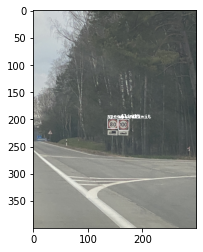

In [8]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


## Split the data into train, test, and validation subsets

We will split the data, and dump them into the subfolder paths defined by `road_sign.yaml`

In [9]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images') if x[-3:] == 'png']
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [10]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

In [11]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')
!mv annotations labels
%cd ../

/notebooks


In [12]:
!mv Road_Sign_Dataset/annotations Road_Sign_Dataset/labels


mv: cannot stat 'Road_Sign_Dataset/annotations': No such file or directory


## Get the `road_sign_data.yaml` and model weight files

In [13]:
# Get old yaml: skip this cell
# !wget -P data/ https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml

--2022-10-20 22:47:52--  https://gist.githubusercontent.com/ayooshkathuria/bcf7e3c929cbad445439c506dba6198d/raw/f437350c0c17c4eaa1e8657a5cb836e65d8aa08a/road_sign_data.yaml
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘data/road_sign_data.yaml.2’

road_sign_data.yaml 100%[===================>]     220  --.-KB/s    in 0s      

2022-10-20 22:47:52 (4.66 MB/s) - ‘data/road_sign_data.yaml.2’ saved [220/220]



In [14]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

--2022-10-20 22:47:53--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt
Resolving github.com (github.com)... ^C


# Execute model training 

In [ ]:
!python train.py --img-size 640 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 100 --data data/road_sign_data.yaml --weights yolov7_training.pt --workers 24 --name yolo_road_det

YOLOR 🚀 072f76c torch 1.12.0+cu116 CUDA:0 (Quadro M4000, 8127.0MB)

Namespace(weights='yolov7_training.pt', cfg='cfg/training/yolov7.yaml', data='data/road_sign_data.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=100, batch_size=8, img_size=[640, 640], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=24, project='runs/train', entity=None, name='yolo_road_det', exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias='latest', freeze=[0], v5_metric=False, world_size=1, global_rank=-1, save_dir='runs/train/yolo_road_det11', total_batch_size=8)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0

# Detect objects in test set

In [16]:
!python detect.py --source Road_Sign_Dataset/images/test/ --weights runs/train/yolo_road_det/weights/best.pt --conf 0.25 --name yolo_road_det

Namespace(weights=['runs/train/yolo_road_det8/weights/best.pt'], source='Road_Sign_Dataset/images/test/', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='yolo_road_det', exist_ok=False, no_trace=False)
YOLOR 🚀 072f76c torch 1.12.0+cu116 CUDA:0 (Quadro M4000, 8127.0MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-de

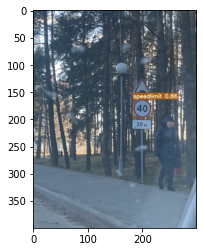

In [18]:
detections_dir = "runs/detect/yolo_road_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
# python detect.py --source 0  # webcam
#                             file.jpg  # image 
#                             file.mp4  # video
#                             path/  # directory
#                             path/*.jpg  # glob
#                             rtsp://170.93.143.139/rtplive/470011e600ef003a004ee33696235daa  # rtsp stream
#                             rtmp://192.168.1.105/live/test  # rtmp stream
#                             http://112.50.243.8/PLTV/88888888/224/3221225900/1.m3u8  # http stream

# Test the model results

In [19]:
!python test.py --weights runs/train/yolo_road_det/weights/best.pt --data road_sign_data.yaml --task test --name yolo_det


Namespace(weights=['runs/train/yolo_road_det8/weights/best.pt'], data='./data/road_sign_data.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='yolo_det', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 072f76c torch 1.12.0+cu116 CUDA:0 (Quadro M4000, 8127.0MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 


Traceback (most recent call last):
  File "/notebooks/test.py", line 319, in <module>
    test(opt.data,
  File "/notebooks/test.py", line 76, in test
    check_dataset(data)  # check
  File "/notebooks/utils/general.py", line 173, in check_dataset
    raise Exception('Dataset no